## Initial settings

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{7}"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

import sys
sys.path.append("..")
import tools as t


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

2024-01-22 20:14:56.771317: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow import keras
import tensorflow as tf

In [4]:
root_path = "/home/dg321/gitTest/PRI/irp/Ventilation/24-01"

## Load data

In [5]:
rawdata = pd.read_csv(root_path + "/AHU Data 20230410.csv")

In [6]:
print(rawdata.shape)
print(rawdata.columns)
print(rawdata.head())

(863, 11)
Index(['Timestamp', 'AI5_AHUintakeAirHumiditySensor (%RH)',
       'AI6_AHUSupplyAirHumiditySensor', 'AI7_ExternalOutsideHumiditySensor',
       'NewGrowRmAvHum', 'NewGrowRmAvTemp', 'UI4_AHUfreshAirTempSensor',
       'UI5_AHUsupplyAirTempSensor', 'UI6_AHUextractAirTempSensor',
       'XXAHUCALCHUMIDITYSETPOINTXX', 'XXAHUCALCTEMPERATURESETPOINTXX'],
      dtype='object')
                   Timestamp  AI5_AHUintakeAirHumiditySensor (%RH)  \
0  01-Apr-23 12:00:00 AM BST                                 76.79   
1  01-Apr-23 12:15:00 AM BST                                 76.12   
2  01-Apr-23 12:30:00 AM BST                                 74.55   
3  01-Apr-23 12:45:00 AM BST                                 75.55   
4   01-Apr-23 1:00:00 AM BST                                 73.18   

   AI6_AHUSupplyAirHumiditySensor  AI7_ExternalOutsideHumiditySensor  \
0                           68.03                              85.48   
1                           67.24                  

In [7]:
print(rawdata["Timestamp"][0])
print(rawdata["Timestamp"][862])

01-Apr-23 12:00:00 AM BST
09-Apr-23 11:45:00 PM BST


In [8]:
rawdata['Timestamp'] = pd.to_datetime(rawdata['Timestamp'])

In [9]:
# Convert timestamp to seconds
timestamp_seconds = (rawdata['Timestamp'] - rawdata['Timestamp'].min()).dt.total_seconds()

# Calculate time sin and time cos
time_sin = np.sin(2 * np.pi * timestamp_seconds / (24 * 60 * 60))
time_cos = np.cos(2 * np.pi * timestamp_seconds / (24 * 60 * 60))

rawdata.insert(1, 'time_sin', time_sin)
rawdata.insert(2, 'time_cos', time_cos)


In [10]:
print(rawdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype                               
---  ------                                --------------  -----                               
 0   Timestamp                             863 non-null    datetime64[ns, pytz.FixedOffset(60)]
 1   time_sin                              863 non-null    float64                             
 2   time_cos                              863 non-null    float64                             
 3   AI5_AHUintakeAirHumiditySensor (%RH)  863 non-null    float64                             
 4   AI6_AHUSupplyAirHumiditySensor        863 non-null    float64                             
 5   AI7_ExternalOutsideHumiditySensor     863 non-null    float64                             
 6   NewGrowRmAvHum                        863 non-null    float64                             
 7   NewGrowRmAvTemp           

In [11]:
column_names_list = rawdata.columns.tolist()

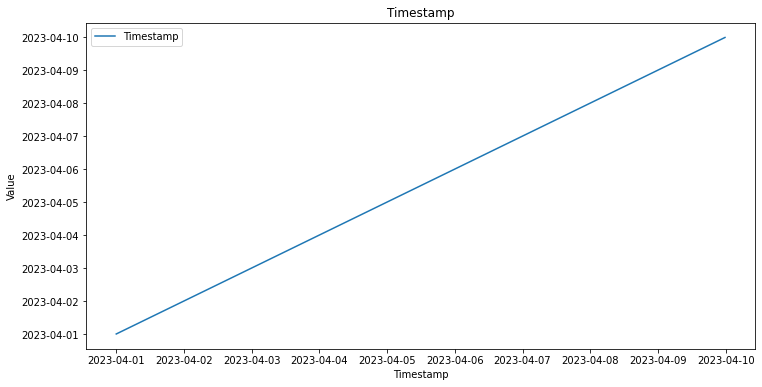

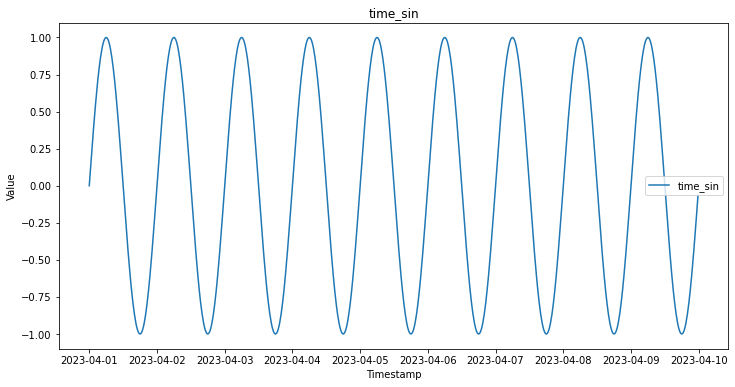

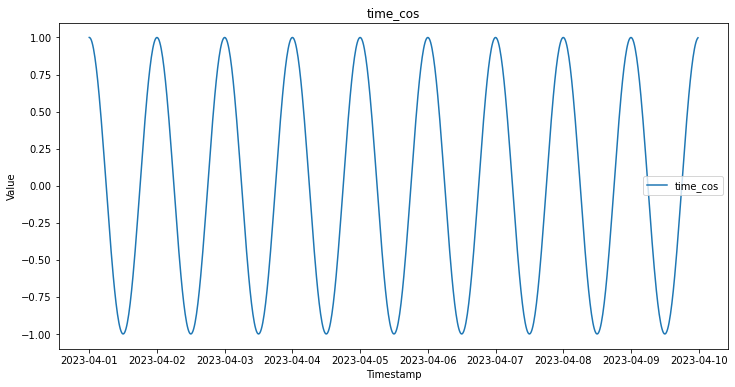

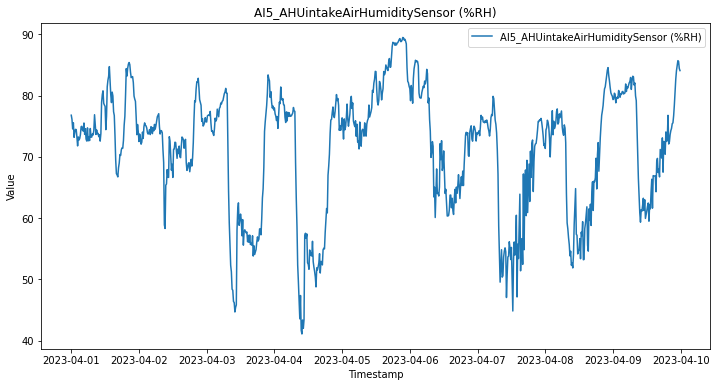

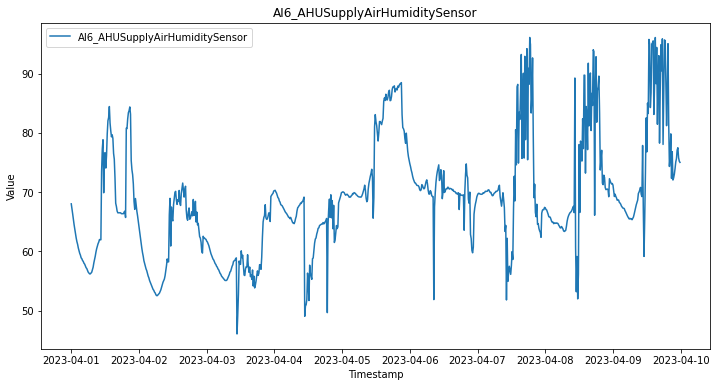

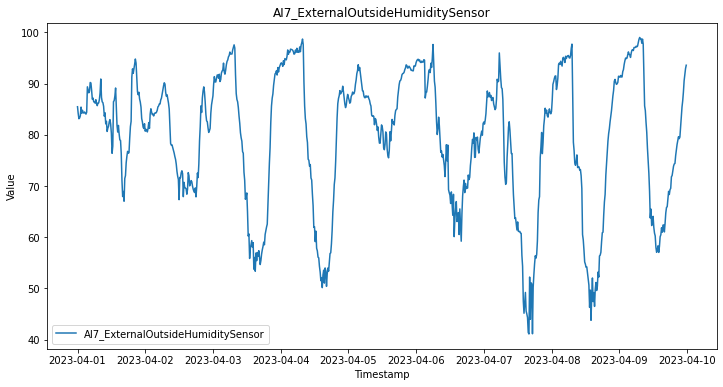

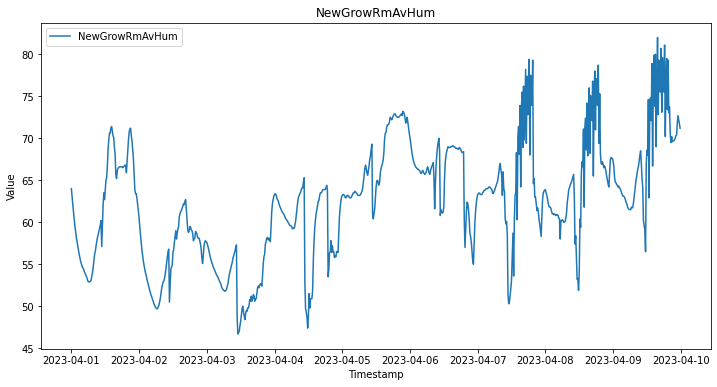

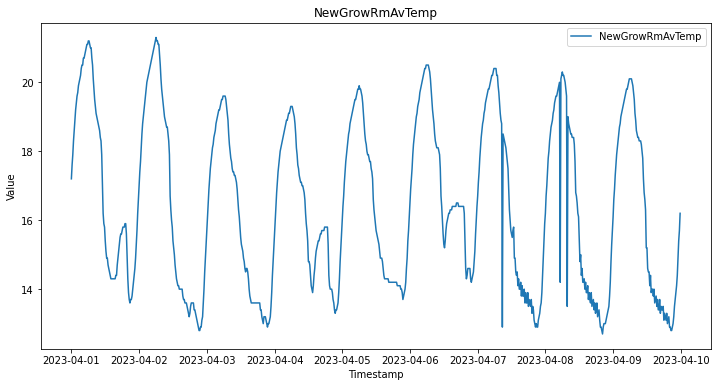

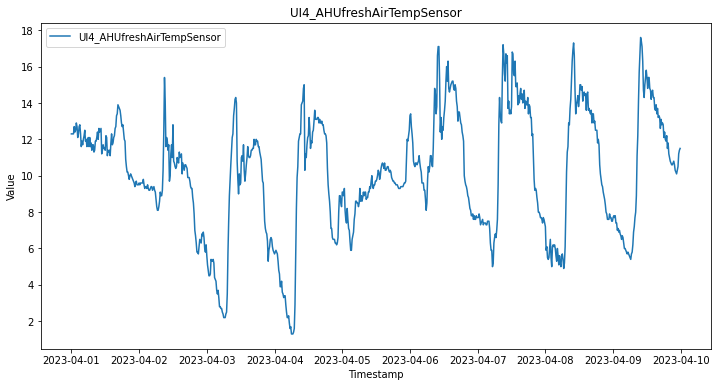

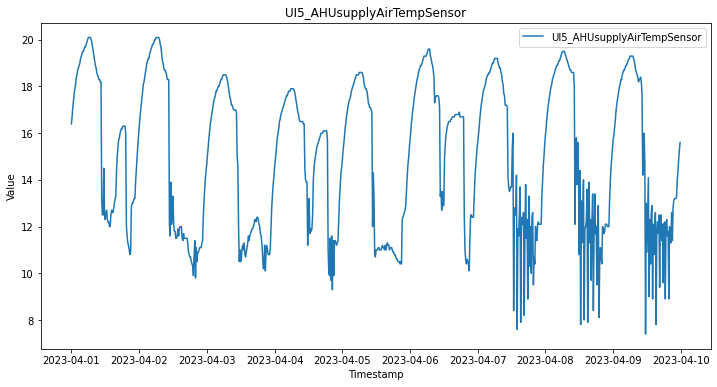

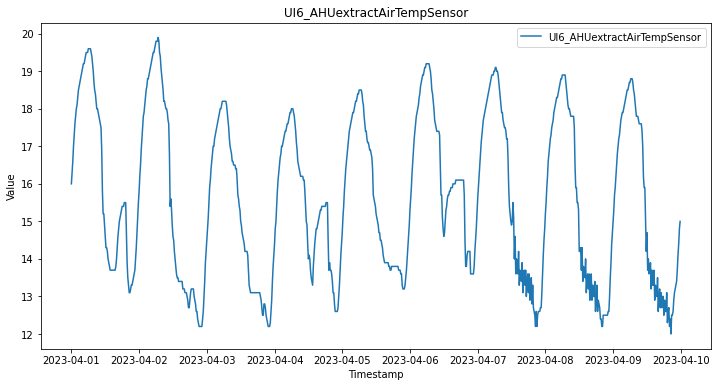

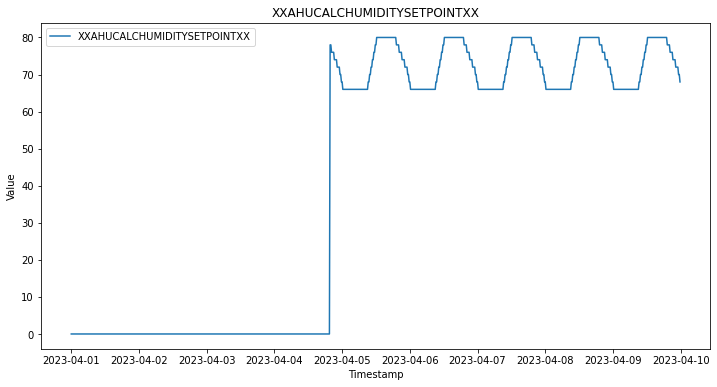

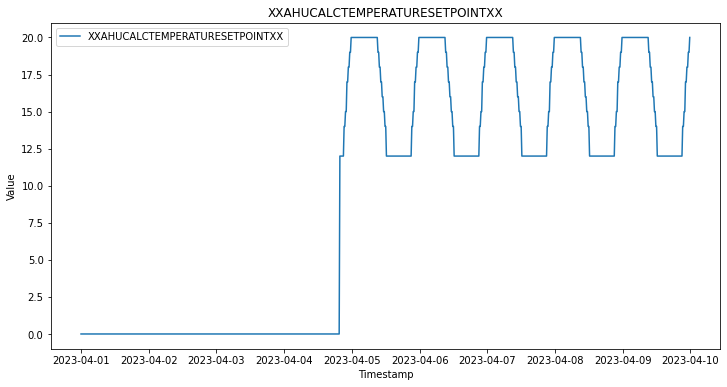

In [12]:
# Plot data over the whole time period

for i in range(rawdata.shape[1]):
    plt.figure(figsize=(12, 6))
    plt.plot(rawdata['Timestamp'], rawdata.iloc[:,i], label=column_names_list[i])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(column_names_list[i])
    plt.legend()
    plt.show()

## Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

data_reducedcols = rawdata.iloc[:, 1:-2]

# Standardize the dataset
scaler = MinMaxScaler()

# Scale the data
scaled_data = scaler.fit_transform(data_reducedcols)

# Save the scaler object
joblib.dump(scaler, root_path + '/scaler.pkl')



/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/home/dg321/gitTest/PRI/irp/Ventilation/24-01/scaler.pkl']

In [14]:
# Choose the first 80% samples as training data
train_samples = int(len(scaled_data) * 0.8)
data_train = scaled_data[:train_samples]
data_test = scaled_data[train_samples:]

train_samples_2 = int(len(data_train) * 0.9)
data_val = data_train[train_samples_2:]
train_data = data_train[:train_samples_2]

In [15]:
print("Training Set Shape:", data_train.shape)
print("Validation Set Shape:", data_val.shape)
print("Test Set Shape:", data_test.shape)


Training Set Shape: (690, 10)
Validation Set Shape: (69, 10)
Test Set Shape: (173, 10)


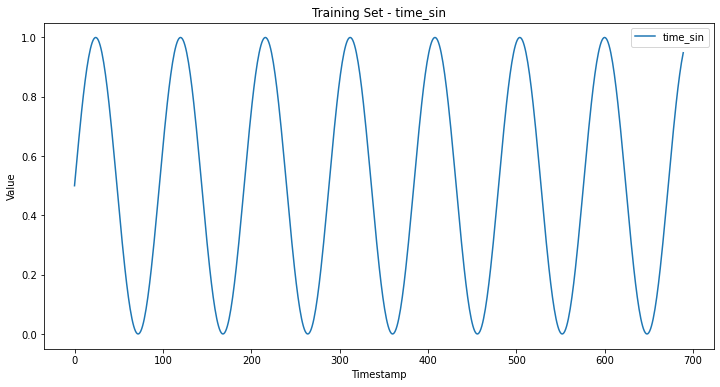

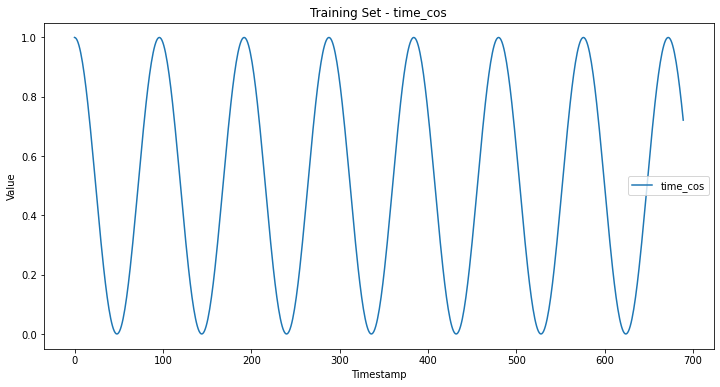

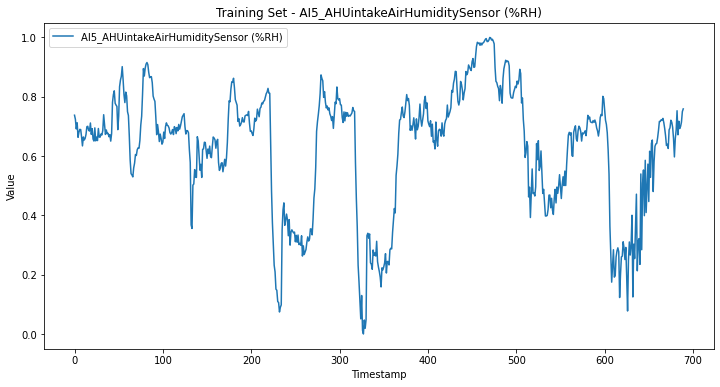

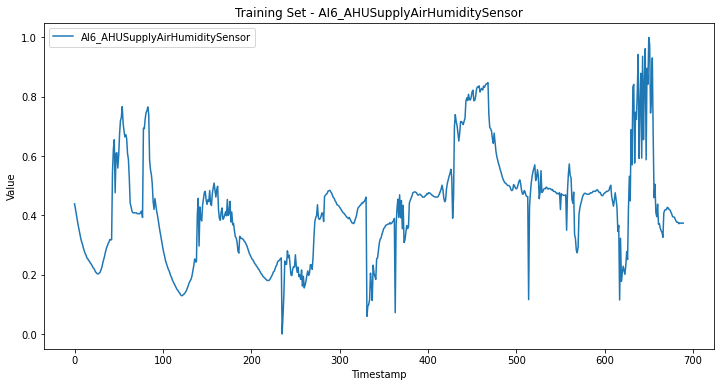

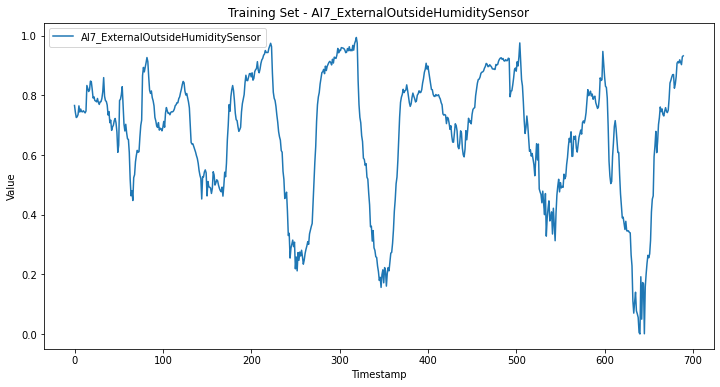

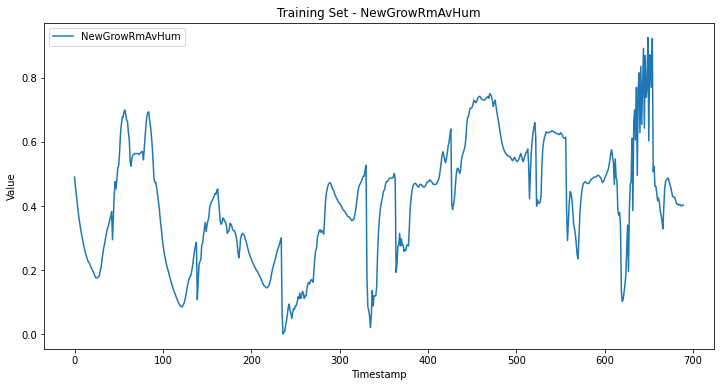

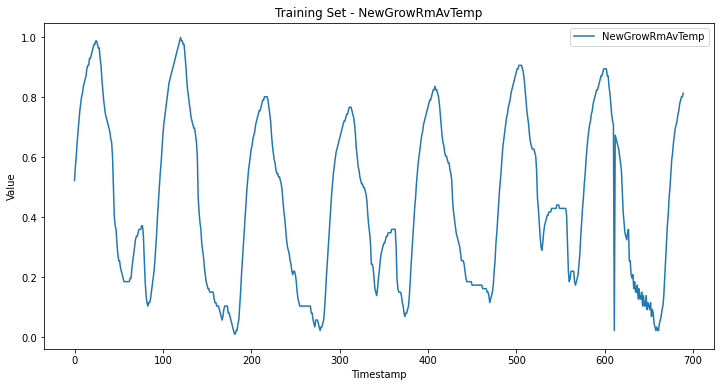

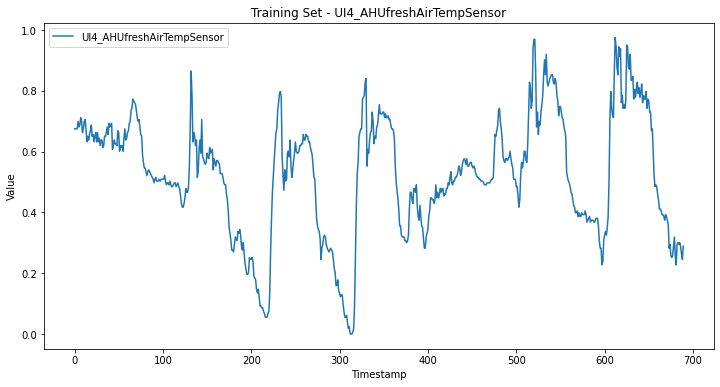

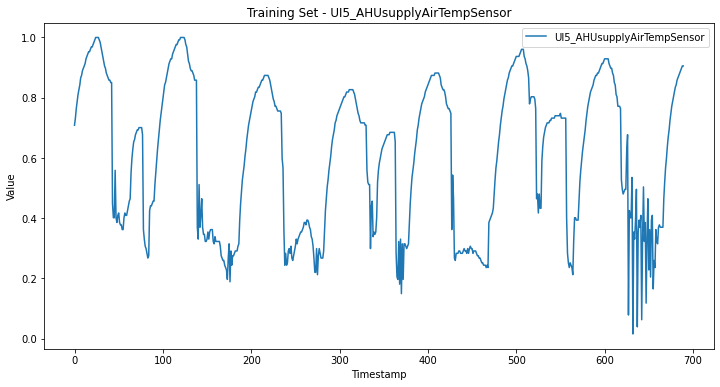

In [16]:
# Plot the first 3 columns for the training set
for i in range(9):
    plt.figure(figsize=(12, 6))
    plt.plot(data_train[:, i], label=column_names_list[i+1])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Training Set - {column_names_list[i+1]}')
    plt.legend()
    plt.show()

# # Plot the first 3 columns for the validation set
# for i in range(3):
#     plt.figure(figsize=(12, 6))
#     plt.plot(data_val[:, i], label=column_names_list[i+1])
#     plt.xlabel('Timestamp')
#     plt.ylabel('Value')
#     plt.title(f'Validation Set - {column_names_list[i+1]}')
#     plt.legend()
#     plt.show()

# # Plot the first 3 columns for the test set
# for i in range(3):
#     plt.figure(figsize=(12, 6))
#     plt.plot(data_test[:, i], label=column_names_list[i+1])
#     plt.xlabel('Timestamp')
#     plt.ylabel('Value')
#     plt.title(f'Test Set - {column_names_list[i+1]}')
#     plt.legend()
#     plt.show()


## Create dataset and dataloader

In [17]:
all_values = data_train
ncoeffs = data_train.shape[1]
print(ncoeffs)
ntimes = 8
BATCH_SIZE = 32
step = 1

10


In [18]:
train_ct = t.concat_timesteps(all_values, ntimes, step)
val_ct = t.concat_timesteps(data_val, ntimes, step)
test_ct = t.concat_timesteps(data_test, ntimes, step)

In [19]:
print("Type of train_ct: ", type(train_ct))
print("Shape of train_ct: ", train_ct.shape)

Type of train_ct:  <class 'numpy.ndarray'>
Shape of train_ct:  (682, 8, 10)


In [20]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# create dataset
# Convert numpy arrays to PyTorch tensors
train_ct_torch = torch.from_numpy(train_ct).float()
val_ct_torch = torch.from_numpy(val_ct).float()

# Create TensorDatasets
train_dataset = TensorDataset(train_ct_torch)
val_dataset = TensorDataset(val_ct_torch)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


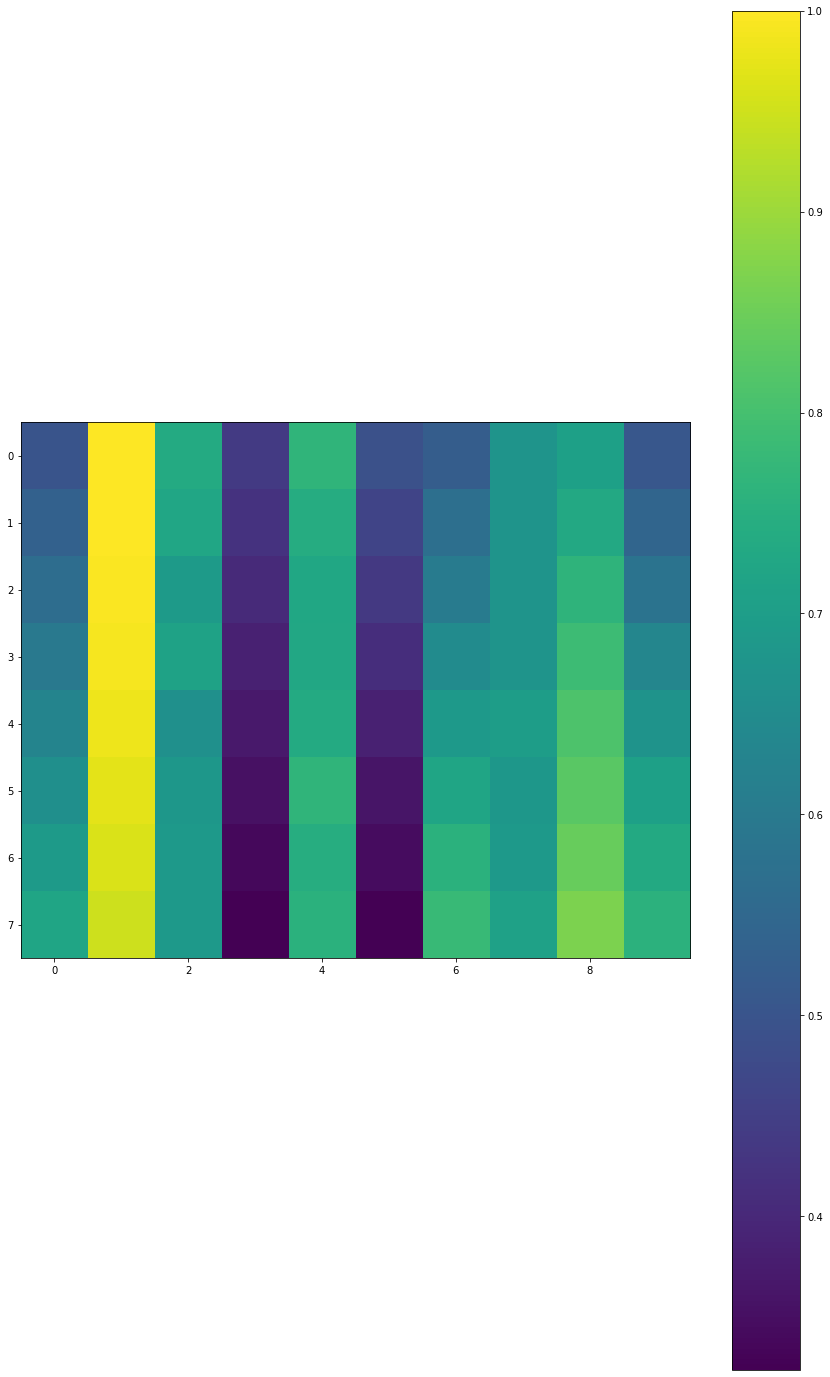

In [21]:
plt.figure(figsize=(15,25))
# Call next() function and get the first element of the tuple
img = next(iter(train_loader))[0][0,:,:]
plt.imshow(img)
plt.colorbar()

## LSTM

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
from copy import deepcopy as dc

end_index = 10

train_ct_fliped = dc(np.flip(train_ct[:,:7, :end_index], axis=1))
test_ct_fliped = dc(np.flip(test_ct[:,:7, :end_index], axis=1))


In [25]:
X_train = torch.tensor(train_ct_fliped).float()
y_train = torch.tensor(train_ct[:,7:, :end_index]).float().squeeze(1)
X_test = torch.tensor(test_ct_fliped).float()
y_test = torch.tensor(test_ct[:,7:, :end_index]).float().squeeze(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([682, 7, 10]),
 torch.Size([165, 7, 10]),
 torch.Size([682, 10]),
 torch.Size([165, 10]))

In [26]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [27]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 10]) torch.Size([16, 10])


In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(10, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=10, bias=True)
)

In [150]:
# def train_one_epoch():
#     model.train(True)
#     print(f'Epoch: {epoch + 1}')
#     running_loss = 0.0
    
#     for batch_index, batch in enumerate(train_loader):
#         x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#         # print(x_batch.shape)
#         # print(y_batch.shape)
        
#         output = model(x_batch)
#         # print(output.shape)
        
        
#         loss = loss_function(output, y_batch)
#         running_loss += loss.item()
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch_index % 100 == 99:  # print every 100 batches
#             avg_loss_across_batches = running_loss / 100
#             print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
#                                                     avg_loss_across_batches))
#             running_loss = 0.0
#     print()

In [151]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [155]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.013
***************************************************

Epoch: 2

Val Loss: 0.013
***************************************************

Epoch: 3

Val Loss: 0.013
***************************************************

Epoch: 4

Val Loss: 0.012
***************************************************

Epoch: 5

Val Loss: 0.013
***************************************************

Epoch: 6

Val Loss: 0.012
***************************************************

Epoch: 7

Val Loss: 0.012
***************************************************

Epoch: 8

Val Loss: 0.012
***************************************************

Epoch: 9

Val Loss: 0.012
***************************************************

Epoch: 10

Val Loss: 0.012
***************************************************

Epoch: 11

Val Loss: 0.012
***************************************************

Epoch: 12

Val Loss: 0.012
***************************************************

Epoch: 13

Val Loss: 0.012
**********************

In [164]:
torch.save(model.state_dict(), root_path + '/lstm/lstm_model_epochs{}.pth'.format(num_epochs))

In [33]:
num_epochs = 100

model = LSTM(10, 4, 1)
model_path = root_path + '/lstm/lstm_model_epochs{}.pth'.format(num_epochs)
model.load_state_dict(torch.load(model_path))
model.to(device)

LSTM(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=10, bias=True)
)

### Predict

torch.Size([682, 10])
(682, 10)


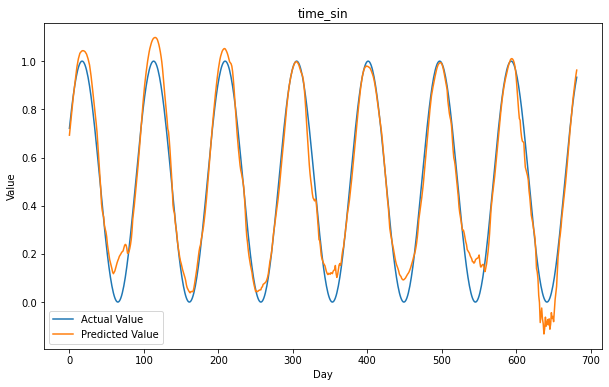

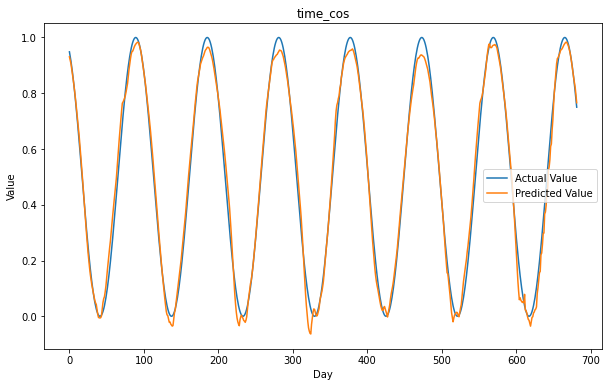

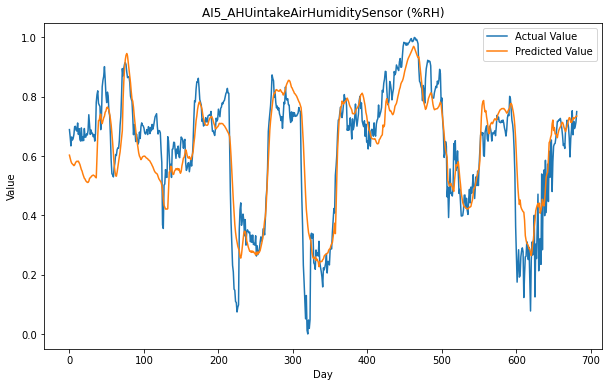

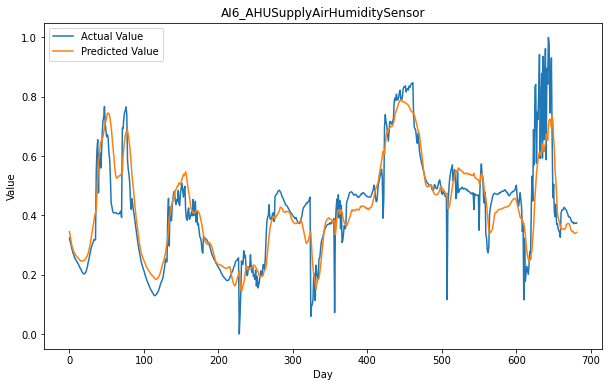

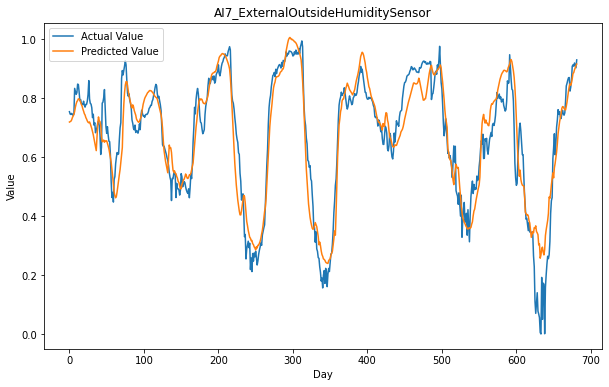

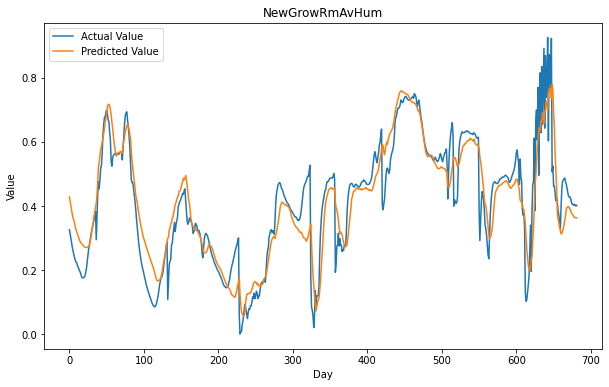

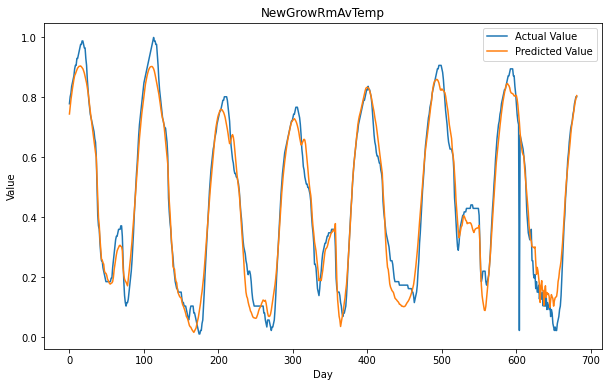

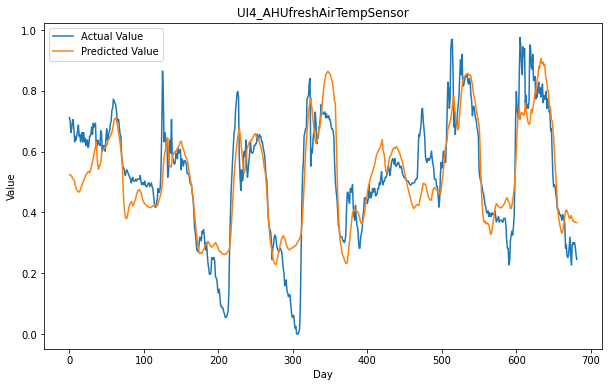

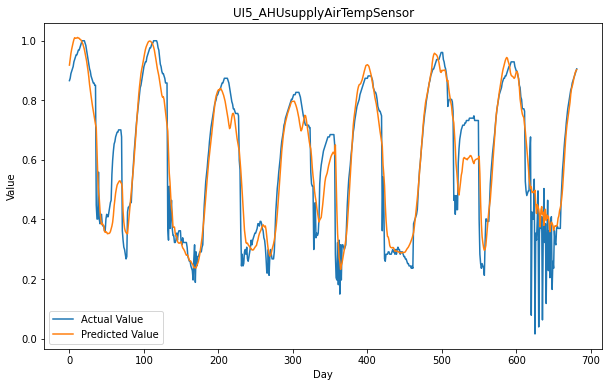

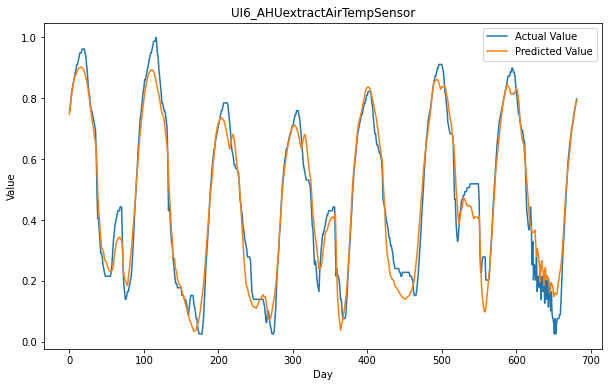

In [34]:
print(y_train.shape)
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    print(predicted.shape)

# Get the number of columns
num_cols = y_train.shape[1]

# Create a plot for each column
for col_index in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train[:,col_index], label='Actual Value')
    plt.plot(predicted[:,col_index], label='Predicted Value')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.title(column_names_list[col_index+1])
    plt.legend()
    plt.show()

torch.Size([165, 10])
(165, 10)


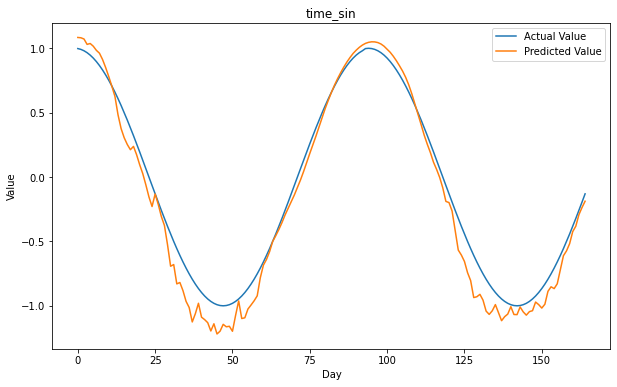

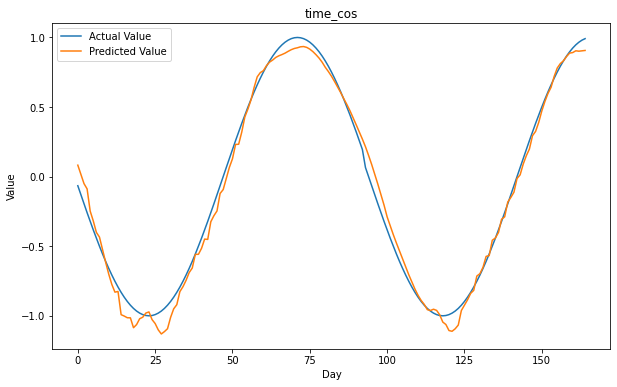

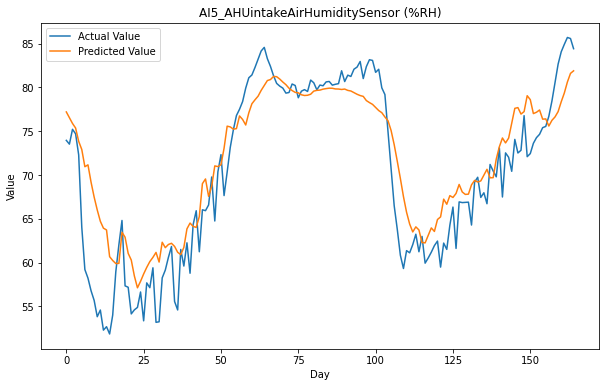

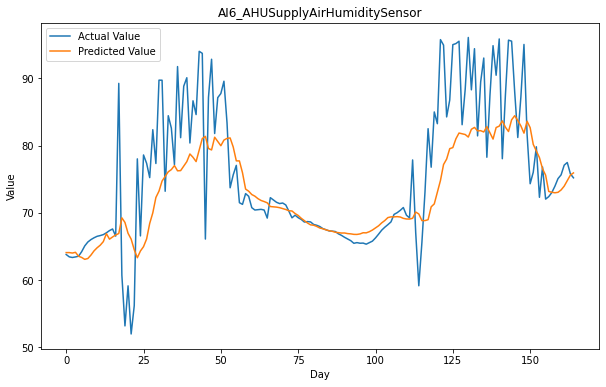

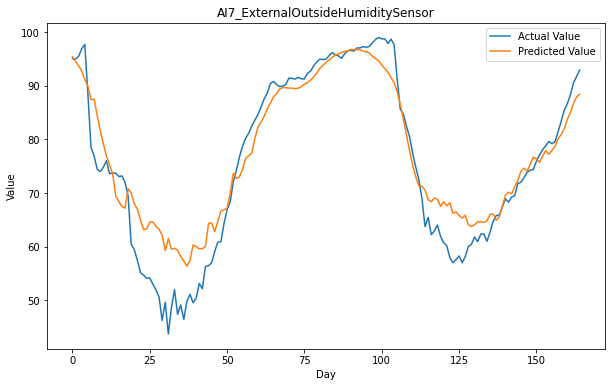

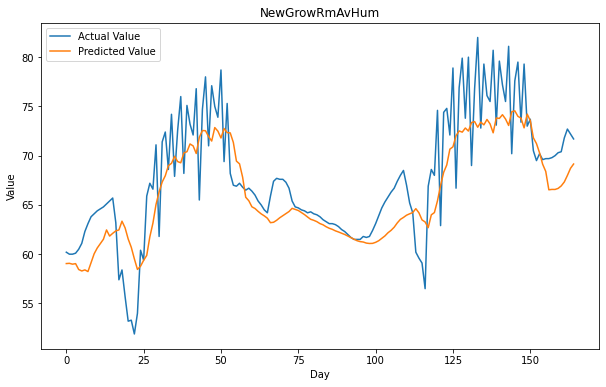

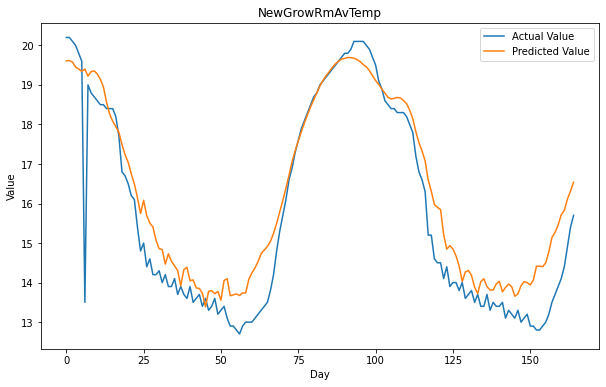

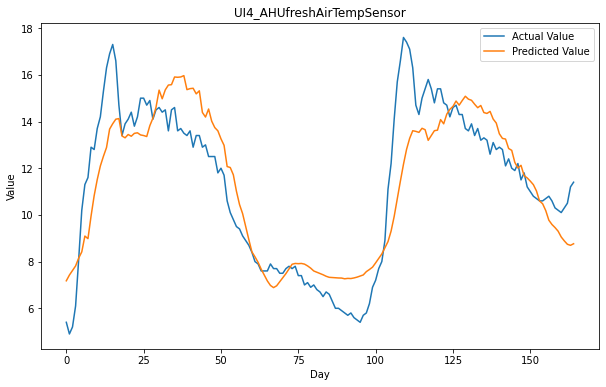

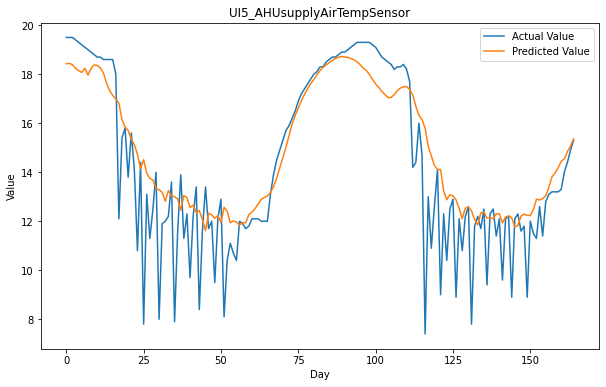

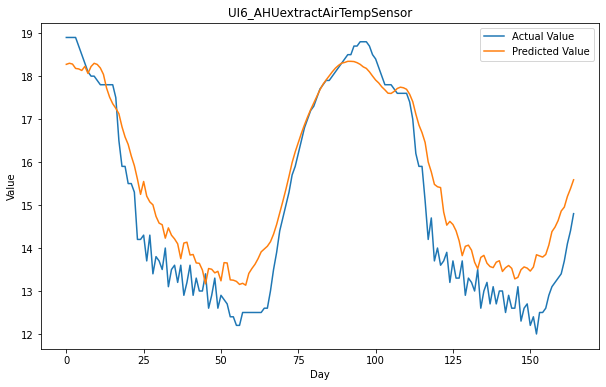

In [165]:
print(y_test.shape)
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()
    print(predicted.shape)

# Inverse transform the data
y_test_inverse = scaler.inverse_transform(y_test)
predicted_inverse = scaler.inverse_transform(predicted)

# Get the number of columns
num_cols = y_test.shape[1]

# Create a plot for each column
for col_index in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inverse[:,col_index], label='Actual Value')
    plt.plot(predicted_inverse[:,col_index], label='Predicted Value')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.title(column_names_list[col_index+1])
    plt.legend()
    plt.show()